<h1 style="Comic Sans MS; text-align: center; color: #FFC300">Sales Forecasting Project</h1>
<h3 id="step1" style="font-family: Comic Sans MS; color: #68FF33">1. Problem statement and data collection</h3>
<p style="color: pink">We want to set up our company's warehouse in another location and we need to estimate the rate of sales, which has been increasing since the company's creation, for the next few months in order to provide the space we will need. We have to construct the valid data structure for the time serie, graph it, and then analyze it and answer the following questions:</p>
<ul style="color: pink">
    <li>Which is the tensor of the time serie?</li>
    <li>Which is the trend?</li>
    <li>Is it stationary?</li>
    <li>Is there variability or noise?</li>
</ul>
<p style="color: pink">Then we will use the training data to find the best parameterization of our ARIMA model and finally we will use the trained model with the test set and compare the points with the real ones and measure the performance of the time serie.</p>

In [129]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [130]:
# Load the data
df = pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv')
df.head()

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


In [131]:
# Setting the index to be the date 
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

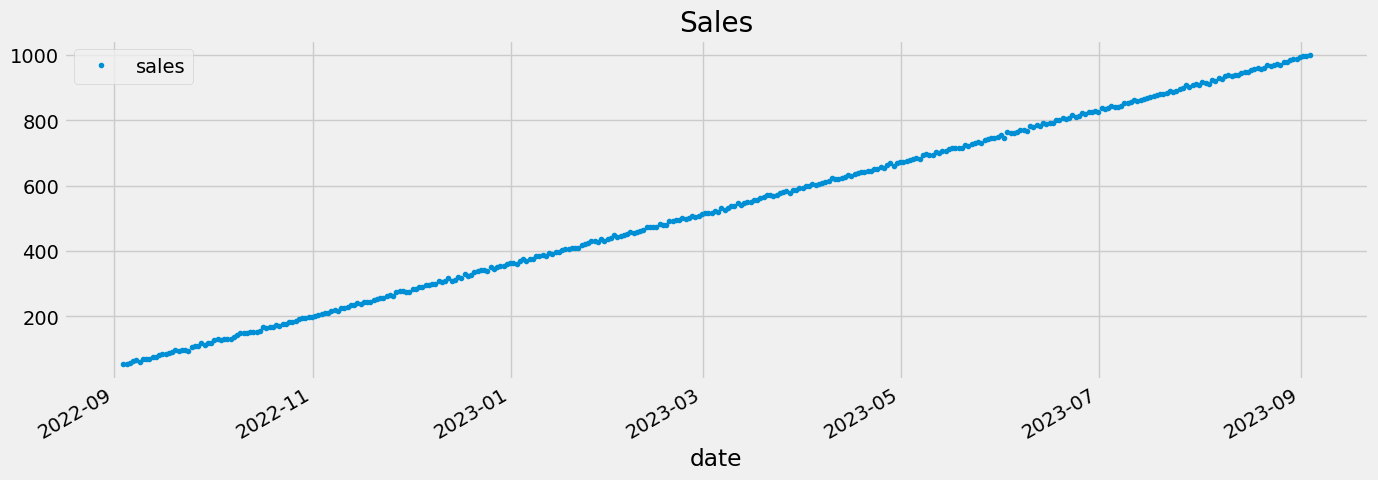

In [132]:
# Let's visualize the data
df.plot(style='.',
        title='Sales',
        color=color_pal[0],
        figsize=(15,5))
plt.show()

<div class="alert alert-block alert-info">
<b>Time Series type:</b> We assume our data has an Increasing Linear Trend inherently in it.</div>

<h3 id="step3" style="font-family: Comic Sans MS; color: #68FF33">3. Analysis of a time series</h3>
<p style="color: pink">To analyze a time series, as we saw in the <a href="https://4geeks.com/syllabus/europe-ds-pt-2/read/time-series" target="_blank">theory</a>, we must study several parameters: trend, seasonability, variability, outliers, and inflection points. For the task of making predictions on time series and analyzing them, we will rely on the <a href="https://www.statsmodels.org/stable/index.html" target="_blank"><b><em>statsmodels</em></b></a> library. Let's go!</p>
<b><span style="color: red">1. Decomposition of the series</span></b>
<p style="color: pink">We use the <a href="https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html#statsmodels.tsa.seasonal.seasonal_decompose" target="_blank">seasonal_decompose</a> function of the statsmodels library to decompose the time series into its trend, seasonality and residuals components.</p>

In [133]:
decomposition = seasonal_decompose(df, model='additive') # model='multiplicative' also works

<b><span style="color: red">2. Trend analysis</span></b>

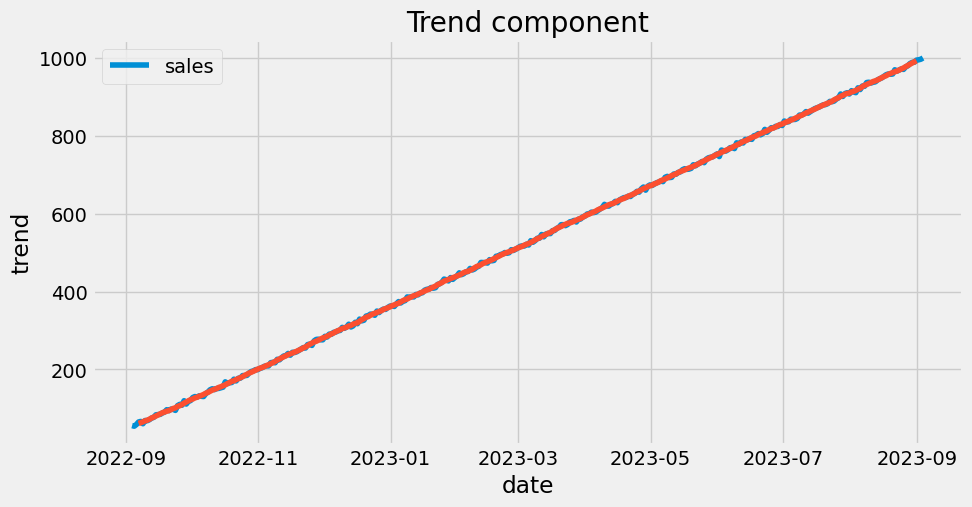

In [134]:
trend = decomposition.trend

fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(data=df, color=color_pal[0], ax=ax)
sns.lineplot(data=trend, color=color_pal[1], ax=ax)
plt.title('Trend component')
plt.show()

<p style="color: pink">This confirms what has been observed: a clear positive trend over the months.</p>

<b><span style="color: red">3. Seasonability analysis</span></b>

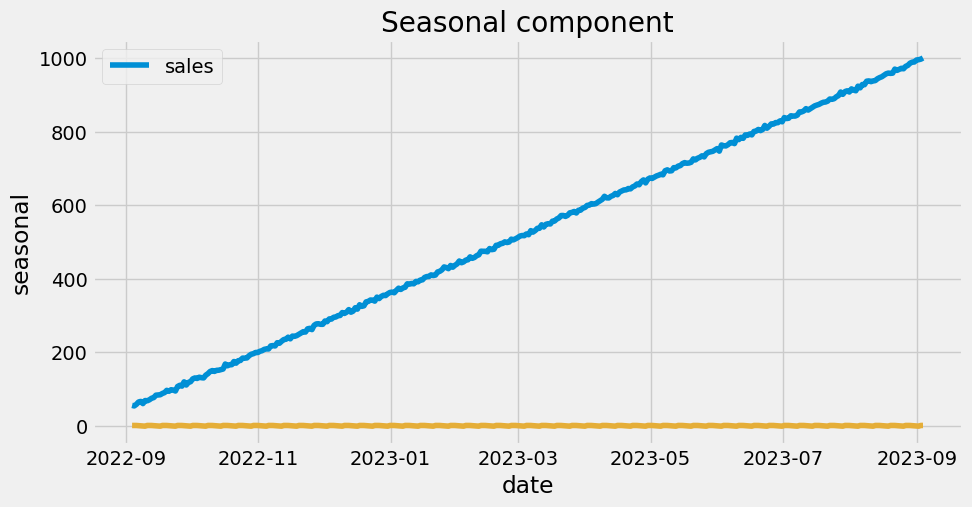

In [135]:
seasonal = decomposition.seasonal

fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(data=df, color=color_pal[0], ax=ax)
sns.lineplot(data=seasonal, color=color_pal[2], ax=ax)
plt.title('Seasonal component')
plt.show()

<b><span style="color: red">3. Evaluate the stationarity of time series: Dickey-Fuller test</span></b>
<p style="color: pink">To evaluate the stationarity of the time series we can apply the so-called Dickey-Fuller test, which is a hypothesis test in which the null hypothesis is that the series is stationary, and the alternative is that it is non-stationary:</p>

In [136]:
def test_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

test_stationarity(df) 

Results of Dickey-Fuller Test:
Test Statistic                   0.545414
p-value                          0.986190
#Lags Used                      13.000000
Number of Observations Used    352.000000
Critical Value (1%)             -3.449065
Critical Value (5%)             -2.869786
Critical Value (10%)            -2.571163
dtype: float64


In [137]:
print(f"The p-value is {adfuller(df)[1]}")
if adfuller(df)[1] > 0.05:
    print("The data is not stationary")
else:
    print("The data is stationary")

The p-value is 0.9861899815311065
The data is not stationary


<p style="color: pink">Here we can see that the p-value is greater than 0.05, this means that our null hypothesis will be rejected and we will take this series as non-stationary.</p>
<b><span style="color: red">4. Analysis of variability</span></b

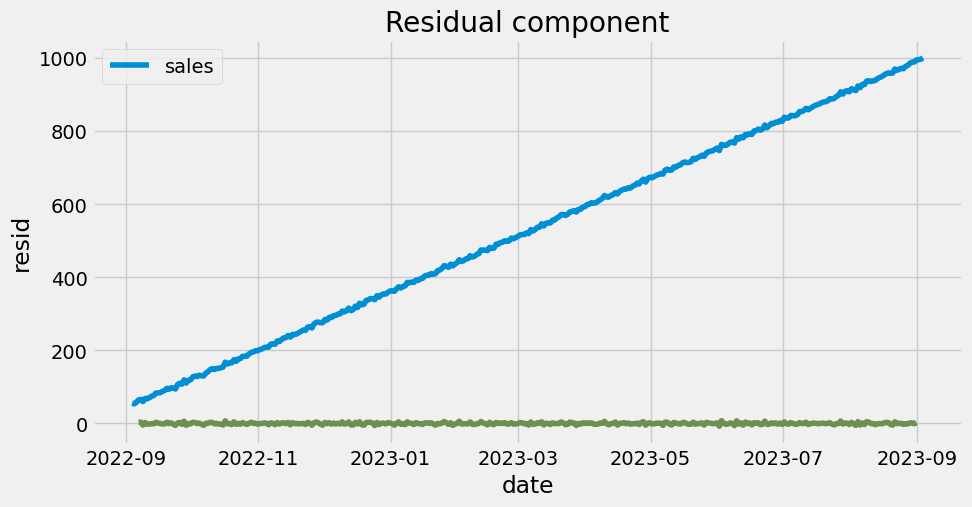

In [138]:
residual = decomposition.resid

fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(data=df, color=color_pal[0], ax=ax)
sns.lineplot(data=residual, color=color_pal[3], ax=ax)
plt.title('Residual component')
plt.show()

<b><span style="color: red">5. Autocorrelation analysis</span></b>
<p style="color: pink">In the context of machine learning and time series analysis, autocorrelation refers to the degree of correlation between a time series and a lagged (shifted) version of itself.Here is how it works:</p>
<ul style="color: pink">
    <li>Lagged Version: Autocorrelation involves comparing the time series with a version of itself that has been shifted by a certain number of time steps, known as a lag. For example, the autocorrelation at lag 1 compares each data point with the data point one time step earlier.</li>
    <li>Correlation Measurement: The autocorrelation function computes the correlation coefficient between the original time series and its lagged version at different lags. It quantifies the extent to which past values of the time series are related to its current value.</li>
</ul>

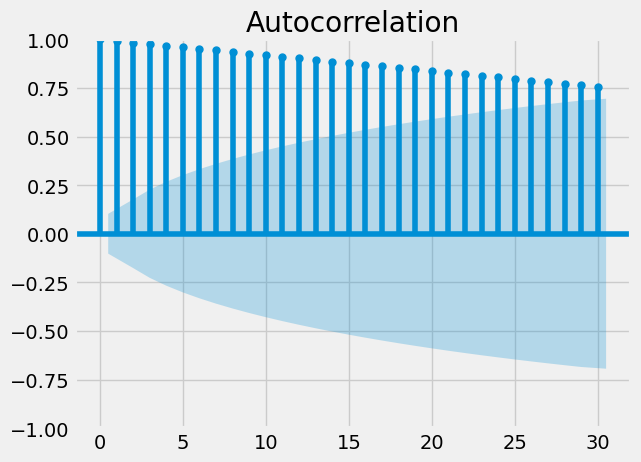

In [139]:
plot_acf(df, lags=30)
plt.show()

<h3 id="step3" style="font-family: Comic Sans MS; color: #68FF33">3. Model training: ARIMA model</h3>

In [140]:
model = auto_arima(df, seasonal=True, m=7, stepwise=True, suppress_warnings=True, trace=True)

Performing stepwise search to minimize aic


 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=2.68 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=2096.542, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=1966.396, Time=0.35 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=inf, Time=0.74 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=2209.657, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=1970.972, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=1968.120, Time=0.39 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=1968.220, Time=0.32 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=1966.919, Time=0.14 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=1965.376, Time=0.96 sec
 ARIMA(1,1,0)(2,0,2)[7] intercept   : AIC=1965.211, Time=1.15 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=1963.937, Time=0.81 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=1967.822, Time=0.30 sec
 ARIMA(0,1,0)(1,0,2)[7] intercept   : AIC=2094.918, Time=0.72 sec
 ARIMA(2,1,0)(1,0,2)[7] intercept   : AIC=1911.553, Time=0.88 sec
 ARIMA(2,1,0)(0,0,2)

In [141]:
print(f"The best ARIMA model is: {model.order}, {model.seasonal_order}")

The best ARIMA model is: (3, 1, 1), (0, 0, 2, 7)


In [142]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                  366
Model:             SARIMAX(3, 1, 1)x(0, 0, [1, 2], 7)   Log Likelihood                -910.882
Date:                                Sun, 31 Mar 2024   AIC                           1837.764
Time:                                        18:24:09   BIC                           1868.963
Sample:                                    09-03-2022   HQIC                          1850.163
                                         - 09-03-2023                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.4112      0.266      9.057      0.000       1.889       2.933
ar.L1         -0.0778      0.053     -1.470      0.142      -0.181       0.026
ar.L2          0.0753      0.058      1.301      0.193      -0.038       0.189
ar.L3          0.0750      0.054      1.387      0.166      -0.031       0.181
ma.L1         -0.9870      0.021    -46.408      0.000      -1.029      -0.945
ma.S.L7        0.1519      0.054      2.816      0.005       0.046       0.258
ma.S.L14       0.0720      0.056      1.290      0.197      -0.037       0.181
sigma2         8.4994      0.667     12.741      0.000       7.192       9.807
===================================================================================
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):                 0.42
Prob(Q):                              0.63   Prob(JB):                         0.81
Heteroskedasticity (H):               0.87   Skew:                             0.05
Prob(H) (two-sided):                  0.44   Kurtosis:                         2.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<h3 id="step3" style="font-family: Comic Sans MS; color: #68FF33">4. Model prediction</h3>

In [143]:
forecast = model.predict(50) # Forecasting the next 50 days

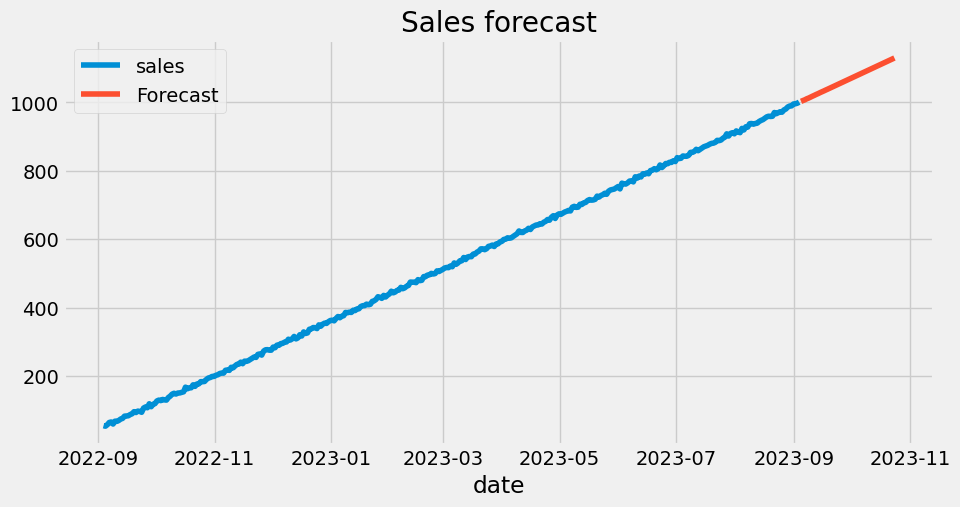

In [147]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(data=df, color=color_pal[0], ax=ax)
sns.lineplot(data=forecast, color=color_pal[1], ax=ax, label='Forecast')
plt.title('Sales forecast')
plt.show()

<div class="alert alert-block alert-success">
<b>Conclusions:</b> We confirm the model is predicting well, in this case we set a prediciton for the next 50 days.
</div>